This notebook can be used to download, extract and process the perturb-CITE-seq data.

It can also be used to replicate **Supplementary Fig. 11, 13, 14A**.

In [1]:
from importlib import reload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
import networkx as nx
import itertools
import pickle
from tqdm import tqdm
# import gseapy
# from gseapy.plot import barplot, dotplot
from causaldag import rand, partial_correlation_suffstat, partial_correlation_test, MemoizedCI_Tester, gsp

In [3]:
# Specify directories
data_dir = "/Tmp/rushil/data/"
save_dir = "/Tmp/rushil/data/"

# Exploratory data analysis
- Article: https://www.nature.com/articles/s41588-021-00779-1
- Data: https://singlecell.broadinstitute.org/single_cell/study/SCP1064/multi-modal-pooled-perturb-cite-seq-screens-in-patient-models-define-novel-mechanisms-of-cancer-immune-evasion#study-download

To run the following script, download data (RNA_expression.csv) to `data_dir` 

### Load cell informations

In [4]:
# Combine sgRNAs assignments and RNA metadata
sgRNA_assignments_df = pd.read_csv(data_dir+'all_sgRNA_assignments.txt', header=0, index_col=0,
                                   names=['cell', 'sgRNAs'])
RNA_metadata_df = pd.read_csv(data_dir+'RNA_metadata.csv', header=0, index_col=0,
                              names=['cell', 'library_prep', 'condition', 'MOI', 'sgRNA', 'UMI_count'])
RNA_UMAP_df = pd.read_csv(data_dir+'RNA_UMAP_cluster.csv', header=0, index_col=0,
                          names=['cell', 'UMAP1', 'UMAP2'])
cell_metadata_df = pd.concat([RNA_metadata_df, sgRNA_assignments_df, RNA_UMAP_df], axis=1)

/tmp/ipykernel_250284/2551039175.py:4: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  RNA_metadata_df = pd.read_csv(data_dir+'RNA_metadata.csv', header=0, index_col=0,


In [5]:
# Include additional information
cell_metadata_df['sgRNAs'] = cell_metadata_df['sgRNAs'].astype(str)
cell_metadata_df['sgRNAs'] = cell_metadata_df['sgRNAs'].str.replace('nan','')
cell_metadata_df['sgRNAs'] = cell_metadata_df['sgRNAs'].apply(lambda x: x.split(','))
cell_metadata_df = cell_metadata_df[['library_prep', 'condition', 'UMI_count', 'MOI', 'sgRNAs', 'UMAP1', 'UMAP2']]

In [6]:
# Dtermine unique target genes for each cell
cell_metadata_df['target_genes'] = cell_metadata_df['sgRNAs'].apply(lambda x: np.unique([guide.split('_')[0] 
                                                                                        for guide in x]))
cell_metadata_df['target_genes_id'] = cell_metadata_df['target_genes'].apply(lambda x: '_'.join(sorted(x)))
cell_metadata_df['n_target_genes'] = cell_metadata_df['target_genes'].apply(lambda x: len(x) if x[0]!='' else 0)
cell_metadata_df.head()

,library_prep,condition,UMI_count,MOI,sgRNAs,UMAP1,UMAP2,target_genes,target_genes_id,n_target_genes
cell,,,,,,,,,,
TYPE,group,group,numeric,numeric,[],numeric,numeric,[],,0
CELL_1,10X 3' v3 sequencing,Control,10832.0,1,[HLA-B_2],-3.9375234,5.441272,[HLA-B],HLA-B,1
CELL_2,10X 3' v3 sequencing,Control,10731.0,2,"[NGFR_3, SERPINF1_3]",-5.4808817,6.598254,"[NGFR, SERPINF1]",NGFR_SERPINF1,2
CELL_3,10X 3' v3 sequencing,Control,28821.0,1,[HLA-B_2],-1.0449617,9.840532,[HLA-B],HLA-B,1
CELL_4,10X 3' v3 sequencing,Control,15322.0,2,"[NMRK1_3, S100A6_3]",-2.588797,6.5883565,"[NMRK1, S100A6]",NMRK1_S100A6,2


In [7]:
cell_metadata_df = cell_metadata_df.iloc[1:]

### Load gene information

In [8]:
# Genes measured in scRNA-seq data
genes_df = pd.read_csv(data_dir+'RNA_genenames.csv', header=0)
# genes_df
genes_list = genes_df['GENE'].values
n_genes = len(genes_list)
print(f'Total number of genes measured = {n_genes}')

Total number of genes measured = 23712


### Information across all screens

In [9]:
# General information
n_cells_all = len(cell_metadata_df)
all_guides = np.unique(sorted(itertools.chain.from_iterable(cell_metadata_df['sgRNAs'].values)))[1:]
all_positive_guides = np.array([guide for guide in all_guides 
                            if ((guide[:17]!='ONE_NON-GENE_SITE') & (guide[:7]!='NO_SITE'))])
all_ntc_guides = np.array([guide for guide in all_guides
                      if ((guide[:17]=='ONE_NON-GENE_SITE') | (guide[:7]=='NO_SITE'))])
all_genes_targeted = np.unique([guide.split('_')[0] for guide in all_positive_guides])
print(f'Total number of cells = {n_cells_all}')
print(f'Total number of unique guides = {len(all_guides)}')
print(f'Total number of unique positive guides = {len(all_positive_guides)}')
print(f'Total number of unique control guides = {len(all_ntc_guides)}')
print(f'Total number of unique genes targeted = {len(all_genes_targeted)}')

Total number of cells = 218331
Total number of unique guides = 818
Total number of unique positive guides = 744
Total number of unique control guides = 74
Total number of unique genes targeted = 248


### Basic information about the screens

In [ ]:
# Visualization (UMAP based on scRNAseq)
plt.figure()
sns.scatterplot(data=cell_metadata_df, x='UMAP1', y='UMAP2', hue='condition', alpha=0.5, s=1)
plt.legend(loc='upper left')
plt.show()

In [10]:
# Number of cells
conditions = cell_metadata_df["condition"].unique()
n_cells = {c: len(cell_metadata_df[cell_metadata_df['condition']==c]) for c in conditions}
screens_size = pd.DataFrame({'condition': n_cells.keys(), 'n_cells': n_cells.values()})
print(f'Conditions = {conditions}')
print(f'Total number of cells in control = {n_cells["Control"]}')
print(f'Total number of cells in IFNγ = {n_cells["IFNγ"]}')
print(f'Total number of cells in co-culture = {n_cells["Co-culture"]}')

Conditions = ['Control' 'IFNγ' 'Co-culture']
Total number of cells in control = 57627
Total number of cells in IFNγ = 87590
Total number of cells in co-culture = 73114


In [11]:
# General information on guides and targets
guides = {c: np.unique(
    sorted(itertools.chain.from_iterable(cell_metadata_df[cell_metadata_df['condition']==c]['sgRNAs'].values))
)[1:] for c in conditions}
positive_guides = {c: np.array([guide for guide in guides[c] 
                                if ((guide[:17]!='ONE_NON-GENE_SITE') & (guide[:7]!='NO_SITE'))]) 
                   for c in conditions}
ntc_guides = {c: np.array([guide for guide in guides[c] 
                           if ((guide[:17]=='ONE_NON-GENE_SITE') | (guide[:7]=='NO_SITE'))]) 
              for c in conditions}
genes_targeted ={c: np.unique([guide.split('_')[0] for guide in positive_guides[c]]) for c in conditions}
all_perturb = {c: np.sort(cell_metadata_df[cell_metadata_df['condition']==c]['target_genes_id'].unique()) 
               for c in conditions}

In [12]:
# Create summary dataframe
summary_df = pd.DataFrame(0, index=conditions, columns=['n_cells', 
                                                        'n_pos_guides', 'n_ntc_guides', 
                                                        'n_genes_pert', 'n_combinations_pert'])
for c in conditions:
    summary_df.loc[c, 'n_cells'] = n_cells[c]
    summary_df.loc[c, 'n_pos_guides'] = len(positive_guides[c])
    summary_df.loc[c, 'n_ntc_guides'] = len(ntc_guides[c])
    summary_df.loc[c, 'n_genes_pert'] = len(genes_targeted[c])
    summary_df.loc[c, 'n_combinations_pert'] = len(all_perturb[c])
summary_df

,n_cells,n_pos_guides,n_ntc_guides,n_genes_pert,n_combinations_pert
Control,57627,743,74,248,17156
IFNγ,87590,744,74,248,19131
Co-culture,73114,742,74,248,13217


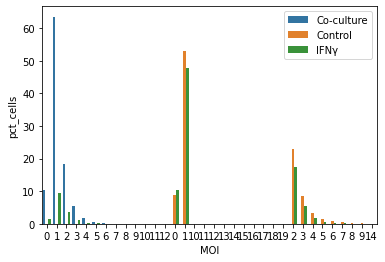

In [13]:
# MOI for all three conditions (number of distinct sgRNA oper cell)
grouped_data = cell_metadata_df.groupby(['condition', 'MOI']).size().to_frame('size').reset_index()
grouped_data = grouped_data.merge(screens_size, how='outer', on='condition')
grouped_data['pct_cells'] = 100*grouped_data['size']/grouped_data['n_cells']
plt.figure()
sns.barplot(data=grouped_data, x='MOI', y='pct_cells', hue='condition')
plt.legend(loc='upper right')
plt.show()

### Dictionary of available perturbations for each screen

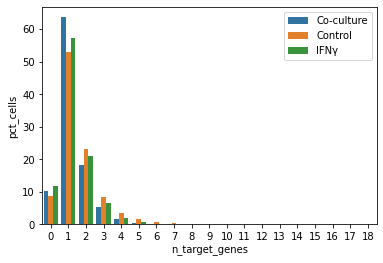

In [14]:
# Number of genes targeted for all three conditions (number of distinct sgRNA oper cell)
grouped_data2 = cell_metadata_df.groupby(['condition', 'n_target_genes']).size().to_frame('size').reset_index()
grouped_data2 = grouped_data2.merge(screens_size, how='outer', on='condition')
grouped_data2['pct_cells'] = 100*grouped_data2['size']/grouped_data2['n_cells']
plt.figure()
sns.barplot(data=grouped_data2, x='n_target_genes', y='pct_cells', hue='condition')
plt.legend(loc='upper right')
plt.show()

In [24]:
# Build dictionary

pertub_dict = {'Control': {}, 'IFNγ': {}, 'Co-culture': {}}
for screen in conditions:
    pertub_dict[screen] = {pert: cell_metadata_df[(cell_metadata_df['condition']==screen) &
                                                  (cell_metadata_df['target_genes_id']==pert)].index.values 
                           for pert in tqdm(all_perturb[screen])}

with open(save_dir+'pertub_dict.pkl', 'wb') as f:
    pickle.dump(pertub_dict, f)

  0%|          | 0/17156 [00:00<?, ?it/s]

100%|██████████| 13217/13217 [04:04<00:00, 54.09it/s]


### Example: access scRNA-seq data for a given perturbation in a given screen

In [15]:
# Load screen-pertubation-sample dictionary
with open(save_dir+'pertub_dict.pkl', 'rb') as f:
    pertub_dict = pickle.load(f)

In [16]:
# Screen and perturbation
screen = 'Control'
a = all_perturb[screen][1]
x = pertub_dict[screen][a]

In [17]:
# scRNA-seq data
rna_path = data_dir+'RNA_expression.csv'
selected_rna_df = pd.read_csv(rna_path, header=0, index_col=0, sep=',', usecols=np.concatenate([['GENE'], x]))
selected_rna_df

,CELL_88,CELL_931,CELL_1349,CELL_1517,CELL_1945,CELL_2087,CELL_2452,CELL_2560,CELL_3248,CELL_3589,...,CELL_53146,CELL_53269,CELL_54356,CELL_54388,CELL_54919,CELL_55512,CELL_56125,CELL_57120,CELL_57219,CELL_57493
GENE,,,,,,,,,,,,,,,,,,,,,
A1BG,0.0,0.000000,3.682174,0.000000,4.698248,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,4.120284,0.000000,0.0,0.0,5.053190
A1BG-AS1,0.0,0.000000,3.682174,0.000000,4.698248,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
A1CF,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
A2M,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
A2M-AS1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.0,4.176153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
ZYG11A,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
ZYG11B,0.0,0.000000,0.000000,0.000000,0.000000,3.629909,0.000000,0.000000,0.00000,3.933592,...,4.779776,0.0,0.000000,4.408776,0.0,0.000000,0.000000,0.0,0.0,0.000000


# Select genes

### Targeted genes

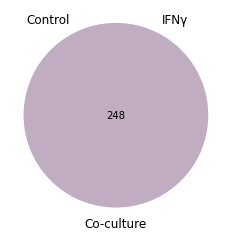

In [18]:
# Compare genes targeted in all screens
plt.figure()
venn3(subsets = [set(genes_targeted[c]) for c in conditions], 
      set_labels = conditions)
plt.show()

/u/guptarus/miniconda3/envs/actlearn/lib/python3.9/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)


2249


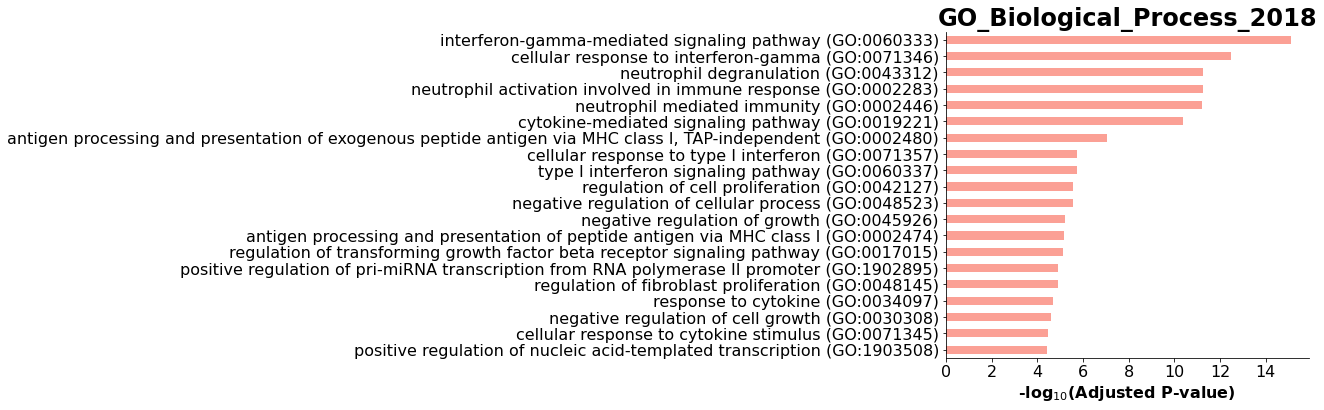

In [19]:
# GO analysis of genes
import gseapy
from gseapy.plot import barplot, dotplot
enr = gseapy.enrichr(gene_list=list(all_genes_targeted), gene_sets='GO_Biological_Process_2018', organism='Human',
                     description='targeted_genes', outdir='gsea_top_hic',format='png',
                     verbose=False)
print(len(enr.results))
barplot(enr.res2d, column='Adjusted P-value', title='GO_Biological_Process_2018',
        cutoff=0.01, top_term=20, figsize=(6.5, 6), color='salmon', ofname=None)

### Select genes for our analysis

In [20]:
# Identify all genes in top signaling signaling pathways
top_go_genes = list(itertools.chain.from_iterable(enr.results.head(7)['Genes'].apply(lambda x: x.split(';'))))
top_go_genes = np.unique(top_go_genes)
print(f'Number of top GO genes = {len(top_go_genes)}')

Number of top GO genes = 64


In [21]:
# Target modules and programs (Figure 4d: cofunctional modules and coregulated programs in Perturb-CITE-seq screen)
module1 = ['CD59', 'CDH19', 'IRF3', 'RB1', 'SOX4', 'SP100']
module2 = ['CD58', 'CTSD', 'CXCR4', 'HLA-C', 'HLA-H', 'NUP50-AS', 'SMAD4']
module3 = ['CDK4', 'CTSA', 'FOS', 'HLA-A', 'HLA-E']
module5 = ['EIF3K', 'LAMP2', 'NPC1', 'NPC2', 'SEC11C', 'FBOX32', 'SAT1']
module6 = ['B2M', 'CCR10', 'HLA-B', 'NGFR', 'TGFB1']
programA = ['CLEC2B', 'CTSA', 'CTSB', 'CTSD', 'HLA-DMA', 'HLA-DPA1', 'HLA-DPB1', 'IDO1', 'IFNGR1', 'IFNGR2', 'IRF3', 'SOX4','STAT1', 'STAT3', 'TGFB1']
programB = ['CD58', 'CD59', 'CITED2', 'IL1B', 'ITGA1', 'JUN', 'JUNB', 'NFKBIA', 'SAT1', 'SOX9', 'SP100', 'VEGFA', 'VEGFC']
programC = ['CDK4', 'CENPA', 'CENPE', 'CENPF', 'CENPK', 'CENPM', 'CENPU', 'CENPW', 'CXCL11', 'CXCL12', 'CXCL13', 'DNMT1', 'EGFR', 'HLA-E', 'PSMA2', 'PSMA5', 'PSMB5', 'PSMB7', 'PSMB9', 'PTPN1', 'NPC2', 'TGIF1', 'TOP2A']
programD = ['CDK6', 'COPA', 'DDIT3', 'HLA-DBQI', 'IL32', 'IL6', 'IL7R', 'KPNA2', 'MRTO4', 'MYC', 'NEDD4', 'NRSP1', 'PARPI', 'PARS', 'SERPINE2', 'TGFB2', 'XBPI']
paper_genes = np.concatenate([module1, module2, module3, module5, module6, 
                              programA, programB, programC, programD])
print(f'Number of genes from the paper = {len(paper_genes)}')

Number of genes from the paper = 98


In [22]:
# Combine gene lists and select final list
combined_gene_list = np.unique(np.concatenate([paper_genes, []]))
# Only keep genes that are sequenced in the scRNAseq readout
combined_gene_list = np.array(sorted(set.intersection(*[set(combined_gene_list),set(genes_list)])))
# Only keep genes that have been targeted in the control CRISPR screen
selected_gene_list = np.array(sorted(set.intersection(*[set(combined_gene_list),set(genes_targeted['Control'])])))
print(f'Final number of selected genes = {len(selected_gene_list)}')

Final number of selected genes = 36


In [23]:
# Identify perturbations that only include genes from the selected list
pert_matching_df = pd.DataFrame({'pert_id': all_perturb['Control']})
pert_matching_df['pert_genes'] = pert_matching_df['pert_id'].apply(lambda x: set(x.split('_')))
pert_matching_df['diff_selected'] = pert_matching_df['pert_genes'].apply(lambda x: len(x-set(selected_gene_list)))
pert_matching_df['selected_pert'] = (pert_matching_df['diff_selected']==0)
selected_pert = pert_matching_df[pert_matching_df['selected_pert']]['pert_id'].values
print(f'Number of unique perturbations affecting selected genes = {len(selected_pert)}')

Number of unique perturbations affecting selected genes = 253


# Learn network over selected genes

In [24]:
# Load and save observational samples
obs_sample_names = pertub_dict['Control']['']
obs_samples = pd.read_csv(rna_path, header=0, index_col=0, sep=',', 
                          usecols=np.concatenate([['GENE'], obs_sample_names]))
obs_samples_reduced = obs_samples.loc[selected_gene_list,:]
# obs_samples.to_csv(data_dir+'controlscreen_observational_samples.csv')
obs_samples_reduced.to_csv(data_dir+'controlscreen_observational_samples_reduced.csv')

In [25]:
# Network and observational data
node_names = sorted(selected_gene_list.copy())
nnodes = len(node_names)
nodes = set(range(nnodes))
obs_sample_names = pertub_dict['Control']['']

In [26]:
# Load observational samples (only measured across selected genes)
obs_samples = pd.read_csv(data_dir+'controlscreen_observational_samples_reduced.csv', header=0, index_col=0)
obs_D = obs_samples.T.sort_index(axis=1).values
print(f'Number of observational samples = {len(obs_sample_names)}')

Number of observational samples = 5039


In [27]:
obs_D.shape

(5039, 36)

In [28]:
# Determine fixed order edges from the article
order_1A = list(itertools.product(module1, programA))
order_1B = list(itertools.product(module1, programB))
order_1C = list(itertools.product(module1, programC))
order_2A = list(itertools.product(module2, programA))
order_2B = list(itertools.product(module2, programB))
order_3B = list(itertools.product(module3, programB))
order_3C = list(itertools.product(module3, programC))
order_3D = list(itertools.product(module3, programD))
order_5A = list(itertools.product(module5, programA))
order_5C = list(itertools.product(module5, programC))
order_5D = list(itertools.product(module5, programD))
order_6C = list(itertools.product(module6, programC))
fixed_orders = list(itertools.chain.from_iterable([order_1A, order_1B, order_1C,
                                              order_2A, order_2B,
                                              order_3B, order_3C, order_3D, 
                                              order_5A, order_5C, order_5D, 
                                              order_6C]))
fixed_orders = set([pair for pair in fixed_orders 
                if ((pair[0] in selected_gene_list) & 
                    (pair[1] in selected_gene_list) & 
                    (pair[0] != pair[1]))])
print(f'Number of fixed orders = {len(fixed_orders)}')

Number of fixed orders = 346


In [29]:
col_to_drop = np.where(np.sum(obs_D, axis=0) ==0)[0]
# obs_D_temp = np.delete(obs_D, col_to_drop,axis=1)
col_to_drop

array([], dtype=int64)

In [30]:
# Learn MEC
suffstat = partial_correlation_suffstat(obs_D)
ci_tester = MemoizedCI_Tester(partial_correlation_test, suffstat, alpha=1e-3)
est_dag = gsp(nodes, ci_tester, fixed_orders=fixed_orders)

In [32]:
# Convert to networkx graph
G = nx.DiGraph()
for i in est_dag.nodes:
    G.add_node(i)
for (i, j) in est_dag.arcs:
    G.add_edge(i, j)
H = nx.relabel_nodes(G, {node: node_names[node] for node in range(nnodes)})
with open(save_dir+'estimated_dag.pkl', 'wb') as f:
    pickle.dump(H, f)
with open(save_dir+'gene_dict.pkl', 'wb') as f:
	pickle.dump({node_names[node]:node for node in range(nnodes)}, f)

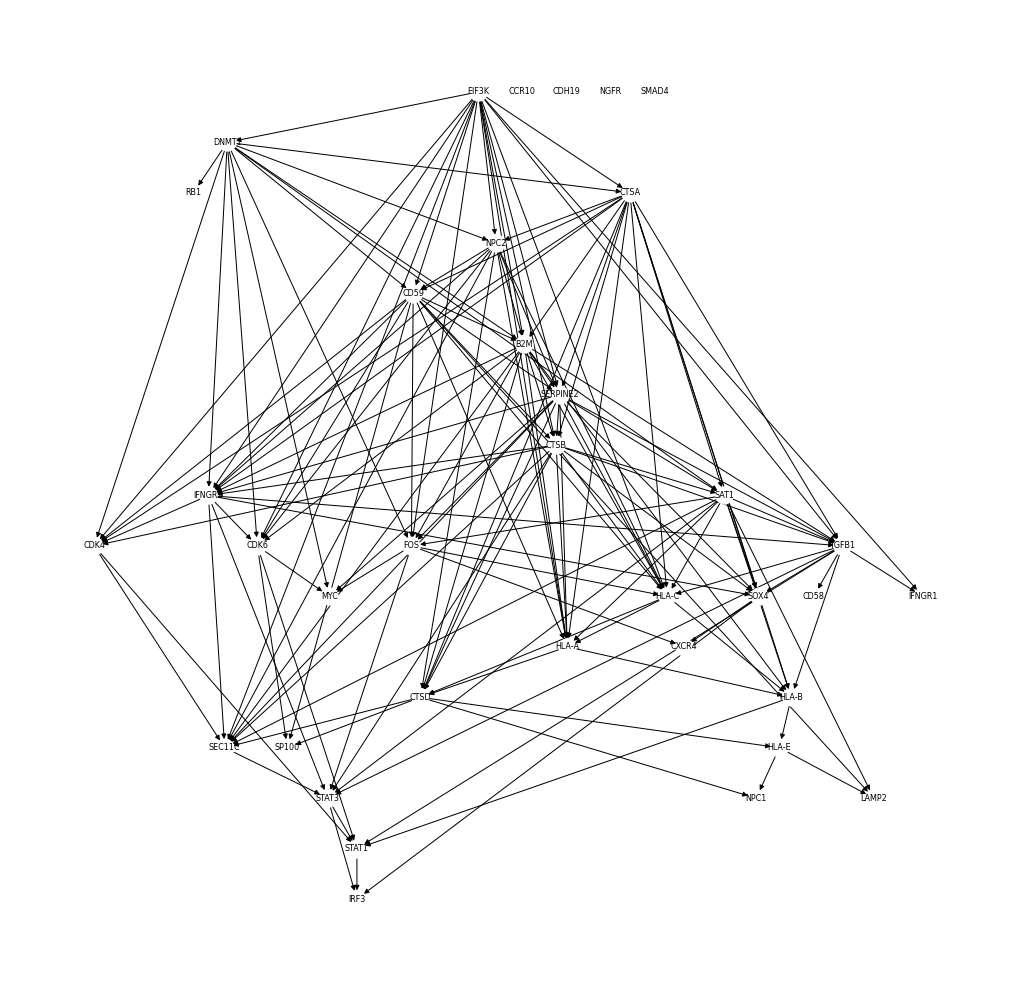

In [33]:
# Draw DAG
from networkx.drawing.nx_agraph import graphviz_layout

nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
plt.gcf().set_size_inches(20, 20)
pos = graphviz_layout(H, 'dot')
nx.draw(H, pos=pos, node_color='w', ax=nw_ax)

nx.draw_networkx_labels(G, pos, labels={s:s for s in H.nodes}, ax=nw_ax, font_size=8);

In [148]:
# Orient other edges based on article

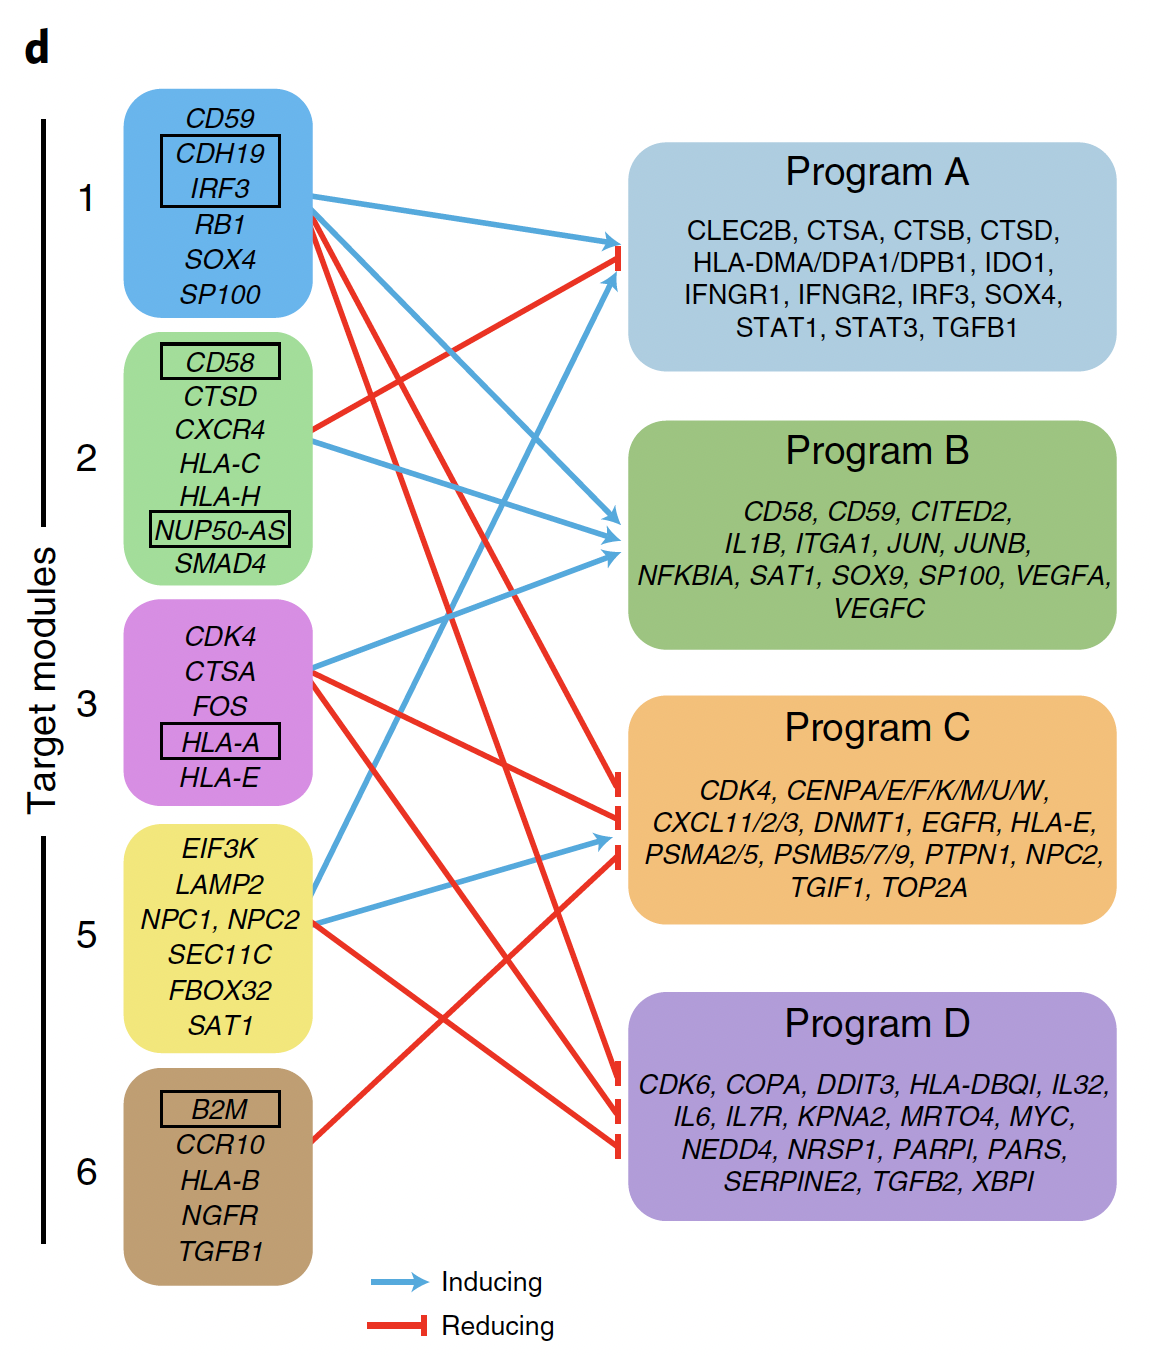

### Supplementary Fig. 14A

In [34]:
color_dict = {}
for g in module1:
	color_dict[g] = 'lightskyblue'
for g in module2:
	color_dict[g] = 'lightgreen'
for g in module3:
	color_dict[g] = 'orchid1'
for g in module5:
	color_dict[g] = 'khaki1'
for g in module6:
	color_dict[g] = 'tan'

b_color_dict = {}
for g in programA:
	b_color_dict[g] = 'cornflowerblue'
for g in programB:
	b_color_dict[g] = 'darkseagreen'
for g in programC:
	b_color_dict[g] = 'sandybrown'
for g in programD:
	b_color_dict[g] = 'mediumpurple'

In [35]:
import graphviz

g = graphviz.Digraph('DAG')
g.attr(ratio='0.6')

for node in H.nodes:
	color = color_dict[node] if node in color_dict.keys() else 'white'
	b_color = b_color_dict[node] if node in b_color_dict.keys() else 'black'
	g.node(node, style='filled,setlinewidth(12)', fillcolor=color, color=b_color, width='4.8', height='3.6', fontsize='72', fontname='Bold-Times-Roman')

for (i,j) in H.edges:
	g.edge(i,j, style='setlinewidth(6)', color='darkgrey', arrowsize='3')

g.view()

'DAG.gv.pdf'